In [1]:
pip install textblob



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [23]:
import json
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob  # For sentiment analysis if needed

# ファイルパスの設定
base_path = 'data/'
files = {
    "character_metadata": "character.metadata.tsv",
    "movie_metadata": "movie.metadata.tsv",
    "name_clusters": "name.clusters.txt",
    "plot_summaries": "plot_summaries.txt",
    "readme": "README.txt",
    "tvtropes_clusters": "tvtropes.clusters.txt"
}

In [13]:
# 1. character.metadata.tsvの読み込みと表示
character_metadata_path = base_path + files["character_metadata"]
character_metadata = pd.read_csv(character_metadata_path, sep='\t')
print("Character Metadata:")
print(character_metadata.head(), "\n")

# 2. movie.metadata.tsvの読み込みと表示
movie_metadata_path = base_path + files["movie_metadata"]
movie_metadata = pd.read_csv(movie_metadata_path, sep='\t')
print("Movie Metadata:")
print(movie_metadata.head(), "\n")

# 3. name.clusters.txtの読み込みと表示
name_clusters_path = base_path + files["name_clusters"]
with open(name_clusters_path, 'r', encoding='utf-8') as f:
    name_clusters = f.readlines()
print("Name Clusters:")
print(name_clusters[:5], "\n")  # 最初の5行を表示

# 4. plot_summaries.txtの読み込みと表示
plot_summaries_path = base_path + files["plot_summaries"]
plot_summaries = pd.read_csv(plot_summaries_path, sep='\t', header=None, names=["movie_id", "plot_summary"])
print("Plot Summaries:")
print(plot_summaries.head(), "\n")

# 5. README.txtの読み込みと表示
readme_path = base_path + files["readme"]
with open(readme_path, 'r', encoding='utf-8') as f:
    readme_content = f.read()
print("README Content:")
print(readme_content[:500], "\n")  # 最初の500文字を表示

# 6. tvtropes.clusters.txtの読み込みと表示
tvtropes_clusters_path = base_path + files["tvtropes_clusters"]
with open(tvtropes_clusters_path, 'r', encoding='utf-8') as f:
    tvtropes_clusters = f.readlines()
print("TV Tropes Clusters:")
print(tvtropes_clusters[:5], "\n")  # 最初の5行を表示


Character Metadata:
   975900  /m/03vyhn  2001-08-24                    Akooshay  1958-08-26  F  \
0  975900  /m/03vyhn  2001-08-24  Lieutenant Melanie Ballard  1974-08-15  F   
1  975900  /m/03vyhn  2001-08-24         Desolation Williams  1969-06-15  M   
2  975900  /m/03vyhn  2001-08-24          Sgt Jericho Butler  1967-09-12  M   
3  975900  /m/03vyhn  2001-08-24             Bashira Kincaid  1977-09-25  F   
4  975900  /m/03vyhn  2001-08-24   Commander Helena Braddock  1949-05-26  F   

    1.62  Unnamed: 7      Wanda De Jesus    42  /m/0bgchxw  /m/0bgcj3x  \
0  1.780  /m/044038p  Natasha Henstridge  27.0   /m/0jys3m  /m/0bgchn4   
1  1.727     /m/0x67            Ice Cube  32.0   /m/0jys3g  /m/0bgchn_   
2  1.750         NaN       Jason Statham  33.0  /m/02vchl6  /m/0bgchnq   
3  1.650         NaN         Clea DuVall  23.0  /m/02vbb3r  /m/0bgchp9   
4  1.727     /m/0x67           Pam Grier  52.0  /m/02vdcfp  /m/0bgchnd   

   /m/03wcfv7  
0   /m/0346l4  
1  /m/01vw26l  
2   /m/034hy

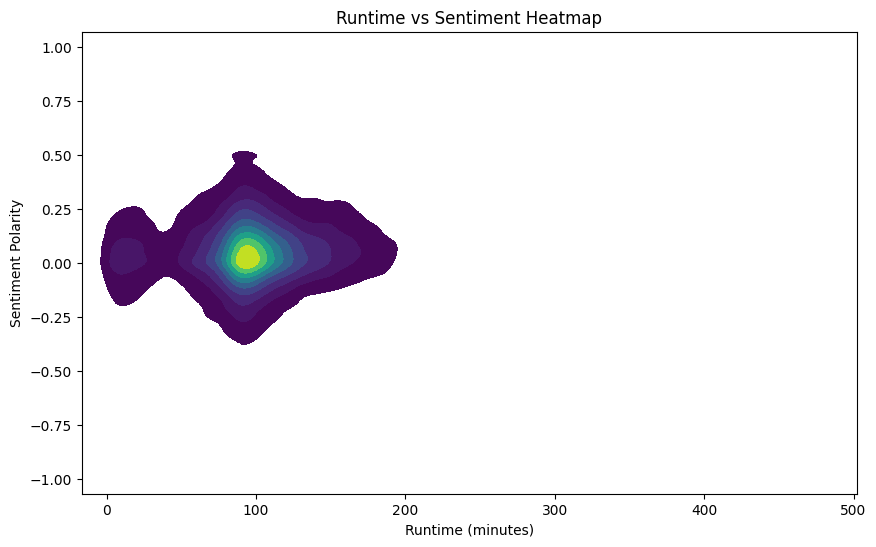

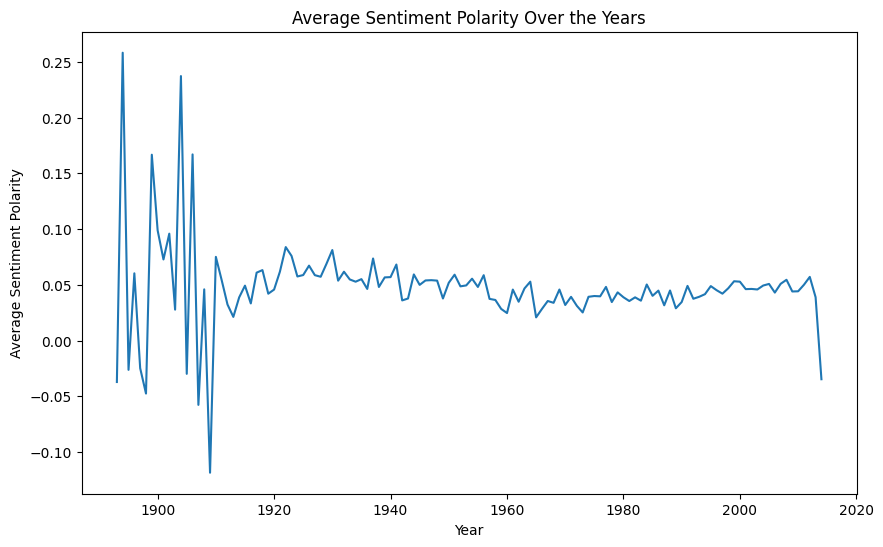

TypeError: unhashable type: 'list'

<Figure size 1200x600 with 0 Axes>

In [26]:

# 1. Character Metadataの読み込み
character_metadata = pd.read_csv(character_metadata_path, sep='\t', header=None)
character_metadata.columns = ['character_id', 'movie_id', 'date', 'character_name', 'birth_date', 'gender', 'height', 'actor_id', 'actor_name', 'actor_age', 'actor_known_for_1', 'actor_known_for_2', 'actor_known_for_3']

# 2. Movie Metadataの読み込み
movie_metadata = pd.read_csv(movie_metadata_path, sep='\t', header=None)
movie_metadata.columns = ['movie_id', 'freebase_id', 'movie_name', 'release_date', 'revenue', 'runtime', 'language', 'country', 'genre']

# 3. Plot Summariesの読み込み
plot_summaries = pd.read_csv(plot_summaries_path, sep='\t', header=None, names=['movie_id', 'plot_summary'])

# 4. TV Tropes Clustersの読み込み
with open(tvtropes_clusters_path, 'r', encoding='utf-8') as f:
    tvtropes_clusters = f.readlines()


# 1. JSONライクな文字列のパース
def parse_json_like_column(column):
    # 正規表現でキーと値を抽出
    return column.apply(lambda x: re.findall(r'":\s*"([^"]+)"', x) if pd.notnull(x) else [])

# 2. country と genre カラムを展開
def expand_column(data, column_name):
    data_expanded = data.dropna(subset=[column_name]).copy()
    data_expanded[column_name] = data_expanded[column_name].apply(lambda x: x if isinstance(x, list) else [x])
    data_expanded = data_expanded.explode(column_name).reset_index(drop=True)
    return data_expanded

# country と genre カラムをリスト化
movie_metadata['country_list'] = parse_json_like_column(movie_metadata['country'])
movie_metadata['genre_list'] = parse_json_like_column(movie_metadata['genre'])

# プロットサマリーの読み込みと感情分析
plot_summaries = pd.read_csv(plot_summaries_path, sep='\t', header=None, names=['movie_id', 'plot_summary'])
data = pd.merge(movie_metadata, plot_summaries, on='movie_id', how='left')
data['year'] = pd.to_datetime(data['release_date'], errors='coerce').dt.year
data['sentiment'] = data['plot_summary'].apply(lambda x: TextBlob(str(x)).sentiment.polarity if pd.notnull(x) else None)
data['description_length'] = data['plot_summary'].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0)

# 1. country と genre カラムを展開し、sentiment列を追加
expanded_country_data = expand_column(data[['movie_id', 'country_list', 'sentiment']], 'country_list')
expanded_genre_data = expand_column(data[['movie_id', 'genre_list', 'sentiment']], 'genre_list')

# country_list と genre_list を文字列に変換してからプロットする
expanded_country_data['country_list'] = expanded_country_data['country_list'].astype(str)
expanded_genre_data['genre_list'] = expanded_genre_data['genre_list'].astype(str)


# 1. Runtime vs Sentimentのヒートマップ表示
def analyze_runtime_vs_sentiment_heatmap(data):
    filtered_data = data[(data['runtime'] <= 500) & (data['runtime'] > 0)]
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=filtered_data, x='runtime', y='sentiment', cmap='viridis', fill=True)
    plt.title('Runtime vs Sentiment Heatmap')
    plt.xlabel('Runtime (minutes)')
    plt.ylabel('Sentiment Polarity')
    plt.show()

# 2. 年ごとの感情の傾向（平均感情極性の変化）
def analyze_yearly_sentiment_trend(data):
    yearly_sentiment = data.groupby('year')['sentiment'].mean().dropna()
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=yearly_sentiment)
    plt.title('Average Sentiment Polarity Over the Years')
    plt.xlabel('Year')
    plt.ylabel('Average Sentiment Polarity')
    plt.show()

# 3. ジャンル別の感情分布
def analyze_genre_sentiment_distribution(data):
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=data, x='genre_list', y='sentiment')
    plt.xticks(rotation=90)
    plt.title('Sentiment Distribution by Genre')
    plt.xlabel('Genre')
    plt.ylabel('Sentiment Polarity')
    plt.show()


# 4. 人気（popularity）がないため、代わりにrevenueで感情と収益の関係を分析
def analyze_revenue_vs_sentiment(data):
    filtered_data = data[data['revenue'] > 0]
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=filtered_data, x='revenue', y='sentiment', alpha=0.5)
    plt.title('Revenue vs Sentiment')
    plt.xlabel('Revenue')
    plt.ylabel('Sentiment Polarity')
    plt.show()

# 5. プロットの長さ（概要テキスト）と感情
def analyze_description_length_vs_sentiment(data):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=data, x='description_length', y='sentiment', alpha=0.5)
    plt.title('Description Length vs Sentiment')
    plt.xlabel('Description Length (words)')
    plt.ylabel('Sentiment Polarity')
    plt.show()

# 6. 国別の感情傾向
def analyze_country_vs_sentiment(data):
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=data, x='country_list', y='sentiment')
    plt.xticks(rotation=90)
    plt.title('Sentiment by Country')
    plt.xlabel('Country')
    plt.ylabel('Sentiment Polarity')
    plt.show()

# 7. パンデミック前後の感情比較
def analyze_pre_post_pandemic_sentiment(data):
    data['pre_pandemic'] = data['year'] < 2020
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=data, x='pre_pandemic', y='sentiment')
    plt.title('Sentiment Before and After Pandemic')
    plt.xlabel('Pre-Pandemic (True=Before, False=After)')
    plt.ylabel('Sentiment Polarity')
    plt.show()

# 各分析の実行
analyze_runtime_vs_sentiment_heatmap(data)
analyze_yearly_sentiment_trend(data)
analyze_genre_sentiment_distribution(data)
analyze_revenue_vs_sentiment(data)
analyze_description_length_vs_sentiment(data)
analyze_country_vs_sentiment(data)
analyze_pre_post_pandemic_sentiment(data)
